In [56]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to suppress all messages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
label_encoder = LabelEncoder()
pd.options.mode.chained_assignment = None


In [60]:
raw_data_path = './data/data_by_table/pre_24h_data.csv'
flag_data_path = './data/data_by_table/ground_truth.csv'

data_df = pd.read_csv(raw_data_path)
flag_data_df = pd.read_csv(flag_data_path)
data_df['gender'] = label_encoder.fit_transform(data_df['gender'])
data_df['race'] = label_encoder.fit_transform(data_df['race'])
data_df['first_careunit'] = label_encoder.fit_transform(data_df['first_careunit'])
data_df['admission_type'] = label_encoder.fit_transform(data_df['admission_type'])
data_df['insurance'] = label_encoder.fit_transform(data_df['insurance'])

In [61]:
def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 

In [62]:
total_x = []
total_y = []
for index, row in flag_data_df.iterrows():
    id_df = data_df[data_df['stay_id'] == row['stay_id']]
    if not check_missing_values(id_df):
        label = id_df['label'].iloc[0]
        if label == 1:
            label = -72
        else:
            if id_df['Rev_h'].iloc[0] != -1000:
                label = 48 - id_df['Rev_h'].iloc[0]
            elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                label = 96 - id_df['dod_h'].iloc[0]*2
            else:
                label = 96
        id_df = id_df.drop(columns='label')
        id_df = id_df.drop(columns='charttime')
        total_x.append(id_df.values)
        total_y.append(label)

total_x = np.array(total_x)
total_y = np.array(total_y).reshape(-1, 1)

print(total_x.shape)
print(total_y.shape)
        

(2840, 24, 26)
(2840, 1)


In [63]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

def train_module(X_train, y_train, X_test, y_test, epoch, learning_rate, batch):

    # Define model and train
    def build_lstm_model(timesteps, num_features):
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(128, input_shape=(timesteps, num_features)),
            tf.keras.layers.Dense(1) 
        ])
        model.build(input_shape=(None, timesteps, num_features))
        return model

    model = build_lstm_model(timesteps=X_train.shape[1], num_features=X_train.shape[2])

    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss='mean_squared_error') 

    model.fit(X_train, y_train, epochs=epoch, batch_size=batch, validation_data=(X_test, y_test))
    return model



In [66]:
total_x = total_x.astype(np.float32)
total_y = total_y.astype(np.float32)
total_x[np.isinf(total_x)] = np.nan
total_x[np.abs(total_x) > 1e6] = np.nan
# Handle NaN values by replacing them with zeros (you can choose a different strategy)
total_x[np.isnan(total_x)] = 0.0
scaler = MinMaxScaler()
total_x_normalized = scaler.fit_transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)

X_train, X_test, y_train, y_test = train_test_split(total_x_normalized, total_y, test_size=0.2)
model = train_module(X_train, y_train, X_test, y_test, epoch= 200, learning_rate=0.001, batch=32)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Epoch 1/200
71/71 [==============================] - 1s 13ms/step - loss: 4464.5005 - val_loss: 4475.2275
Epoch 2/200
71/71 [==============================] - 1s 10ms/step - loss: 4308.2153 - val_loss: 4455.7280
Epoch 3/200
71/71 [==============================] - 1s 10ms/step - loss: 4296.4609 - val_loss: 4454.4463
Epoch 4/200
71/71 [==============================] - 1s 10ms/step - loss: 4295.2563 - val_loss: 4455.3423
Epoch 5/200
71/71 [==============================] - 1s 10ms/step - loss: 4294.0034 - val_loss: 4455.2861
Epoch 6/200
71/71 [==============================] - 1s 10ms/step - loss: 4294.1689 - val_loss: 4455.0815
Epoch 7/200
71/71 [==============================] - 1s 10ms/step - loss: 4293.6392 - val_loss: 4453.8906
Epoch 8/200
71/71 [==============================] - 1s 10ms/step - loss: 4290.6387 - val_loss: 4445.0029
Epoch 9/200
71/71 [==============================] - 1s 10ms/step - loss: 4272.3882 - val_loss: 4412.5249
Epoch 10/200
71/71 [==========================

In [67]:
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0, 1, 0)
y_label = np.where(y_test > 0, 1, 0)
#print(y_pred_proba)
# Calculate AUROC
auroc = roc_auc_score(y_label, y_pred)
print("AUROC:", auroc)

18/18 [==============================] - 0s 6ms/step
AUROC: 0.8392873737172594


In [68]:
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_label, y_pred)
print("Accuracy:", accuracy)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_label, y_pred)
print("AUC-ROC:", auc_roc)

Accuracy: 0.8661971830985915
AUC-ROC: 0.8392873737172594


0.8985755439616605


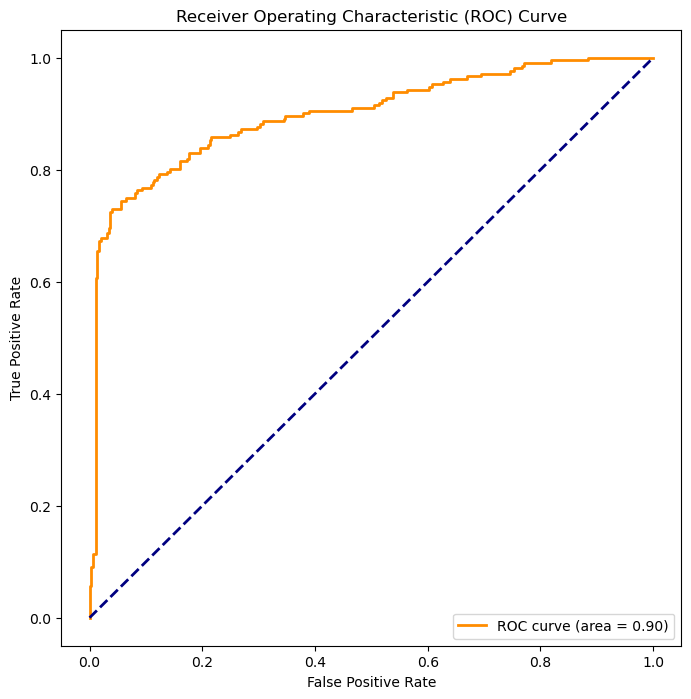

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_label, y_pred_proba)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()